In [196]:
from functools import reduce
from typing import List

import datasets
import json
from pathlib import Path
import evaluate
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchinfo import summary
from tqdm.notebook import tqdm

In [197]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Util functions

In [198]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state  #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [199]:
def compute_clm_loss(logits, labels):
    # Classical Language modeling task (nope)
    # Next token prediction task in causual setup
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()
    loss = F.cross_entropy(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1), ignore_index=-100)
    return loss

In [200]:
def compute_shifted_cosine_mse_loss(input_logits, output_logits, padding_mask):

    losses = []

    batch_size = padding_mask.shape[0]
    for batch_idx in range(batch_size):
        preds = input_logits[batch_idx, :][~padding_mask[batch_idx, :]]
        targets = output_logits[batch_idx, :][~padding_mask[batch_idx, :]]

        shift_input = preds[:-1, :].contiguous()
        shift_output = targets[1:, :].contiguous()

        loss = (1 - F.cosine_similarity(shift_input, shift_output, -1)).mean() + F.mse_loss(shift_input, shift_output)
        losses.append(loss)

    return torch.stack(losses).contiguous().mean()

In [201]:
def compute_shifted_cross_l2_loss(input_logits, output_logits, padding_mask):
    losses = []

    batch_size = padding_mask.shape[0]
    for batch_idx in range(batch_size):

        preds = input_logits[batch_idx, :][~padding_mask[batch_idx, :]]
        targets = output_logits[batch_idx, :][~padding_mask[batch_idx, :]]

        orig_distances = torch.cdist(targets[1:], targets[1:]).detach()
        pred_distances = torch.cdist(preds[:-1], preds[:-1])

        idx = torch.triu_indices(*orig_distances.shape)
        loss = F.mse_loss(pred_distances[idx[0], idx[1]].view(-1), orig_distances[idx[0], idx[1]].view(-1))
        losses.append(loss)

    return torch.stack(losses).contiguous().mean()

In [202]:
def compute_cosine_mse_loss(input_logits, output_logits, padding_mask):

    losses = []

    batch_size = padding_mask.shape[0]
    for batch_idx in range(batch_size):
        preds = input_logits[batch_idx, :][~padding_mask[batch_idx, :]]
        targets = output_logits[batch_idx, :][~padding_mask[batch_idx, :]]
        # print(preds.shape, targets.shape)

        loss = (1 - F.cosine_similarity(preds, targets, -1)).mean() + F.mse_loss(preds, targets)
        losses.append(loss)

    return torch.stack(losses).contiguous().mean()

#### Losses Playground

In [203]:
example_output = torch.rand([5, 8, 100], dtype=torch.float)
example_input = example_output.clone()
example_input[:, :-1] = example_output[:, 1:]
# compute_shifted_mse_loss(example_input, example_output, torch.zeros(5, 8).bool())

In [204]:
F.mse_loss(example_input[0][:-1], example_output[0][1:])

tensor(0.)

In [205]:
F.mse_loss(torch.cdist(example_output[0][1:], example_output[0][1:]).view(-1),
           torch.cdist(example_input[0][:-1], example_input[0][:-1]).view(-1))

tensor(0.)

In [206]:
torch.cdist(example_input[0][:-1], example_input[0][:-1])

tensor([[0.0000, 3.9967, 4.1140, 4.5747, 4.1753, 3.7062, 3.9707],
        [3.9967, 0.0000, 4.4865, 4.6694, 4.3787, 3.6571, 3.9915],
        [4.1140, 4.4865, 0.0000, 4.2886, 4.0478, 3.6570, 3.7794],
        [4.5747, 4.6694, 4.2886, 0.0000, 4.4998, 4.3774, 3.9894],
        [4.1753, 4.3787, 4.0478, 4.4998, 0.0000, 4.1431, 3.9067],
        [3.7062, 3.6571, 3.6570, 4.3774, 4.1431, 0.0000, 3.7294],
        [3.9707, 3.9915, 3.7794, 3.9894, 3.9067, 3.7294, 0.0000]])

In [207]:
torch.cdist(example_output[0][1:], example_output[0][1:])

tensor([[0.0000, 3.9967, 4.1140, 4.5747, 4.1753, 3.7062, 3.9707],
        [3.9967, 0.0000, 4.4865, 4.6694, 4.3787, 3.6571, 3.9915],
        [4.1140, 4.4865, 0.0000, 4.2886, 4.0478, 3.6570, 3.7794],
        [4.5747, 4.6694, 4.2886, 0.0000, 4.4998, 4.3774, 3.9894],
        [4.1753, 4.3787, 4.0478, 4.4998, 0.0000, 4.1431, 3.9067],
        [3.7062, 3.6571, 3.6570, 4.3774, 4.1431, 0.0000, 3.7294],
        [3.9707, 3.9915, 3.7794, 3.9894, 3.9067, 3.7294, 0.0000]])

In [208]:
torch.cdist(example_input[0][:-1], example_output[0][1:])

tensor([[0.0000, 3.9967, 4.1140, 4.5747, 4.1753, 3.7062, 3.9707],
        [3.9967, 0.0000, 4.4865, 4.6694, 4.3787, 3.6571, 3.9915],
        [4.1140, 4.4865, 0.0000, 4.2886, 4.0478, 3.6570, 3.7794],
        [4.5747, 4.6694, 4.2886, 0.0000, 4.4998, 4.3774, 3.9894],
        [4.1753, 4.3787, 4.0478, 4.4998, 0.0000, 4.1431, 3.9067],
        [3.7062, 3.6571, 3.6570, 4.3774, 4.1431, 0.0000, 3.7294],
        [3.9707, 3.9915, 3.7794, 3.9894, 3.9067, 3.7294, 0.0000]])

## Using daily_dialog dataset
This dataset contains emotions and acts, each dialog is a separate list of lines

In [209]:
dd_dataset = datasets.load_dataset('daily_dialog')
dd_dataset

Found cached dataset daily_dialog (/home/hivaze/.cache/huggingface/datasets/daily_dialog/default/1.0.0/1d0a58c7f2a4dab5ed9d01dbde8e55e0058e589ab81fce5c2df929ea810eabcd)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['dialog', 'act', 'emotion'],
        num_rows: 11118
    })
    validation: Dataset({
        features: ['dialog', 'act', 'emotion'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['dialog', 'act', 'emotion'],
        num_rows: 1000
    })
})

In [210]:
dd_dataset['train'][:3]

{'dialog': [['Say , Jim , how about going for a few beers after dinner ? ',
   ' You know that is tempting but is really not good for our fitness . ',
   ' What do you mean ? It will help us to relax . ',
   " Do you really think so ? I don't . It will just make us fat and act silly . Remember last time ? ",
   " I guess you are right.But what shall we do ? I don't feel like sitting at home . ",
   ' I suggest a walk over to the gym where we can play singsong and meet some of our friends . ',
   " That's a good idea . I hear Mary and Sally often go there to play pingpong.Perhaps we can make a foursome with them . ",
   ' Sounds great to me ! If they are willing , we could ask them to go dancing with us.That is excellent exercise and fun , too . ',
   " Good.Let ' s go now . ",
   ' All right . '],
  ['Can you do push-ups ? ',
   " Of course I can . It's a piece of cake ! Believe it or not , I can do 30 push-ups a minute . ",
   " Really ? I think that's impossible ! ",
   ' You mean 30

In [211]:
reduce(lambda x, y: set(x) | set(y), dd_dataset['train']['emotion'])

{0, 1, 2, 3, 4, 5, 6}

In [212]:
reduce(lambda x, y: set(x) | set(y), dd_dataset['train']['act'])

{1, 2, 3, 4}

(array([3.791e+03, 3.057e+03, 2.119e+03, 1.669e+03, 3.110e+02, 1.090e+02,
        4.000e+01, 1.100e+01, 8.000e+00, 3.000e+00]),
 array([ 2. ,  5.3,  8.6, 11.9, 15.2, 18.5, 21.8, 25.1, 28.4, 31.7, 35. ]),
 <BarContainer object of 10 artists>)

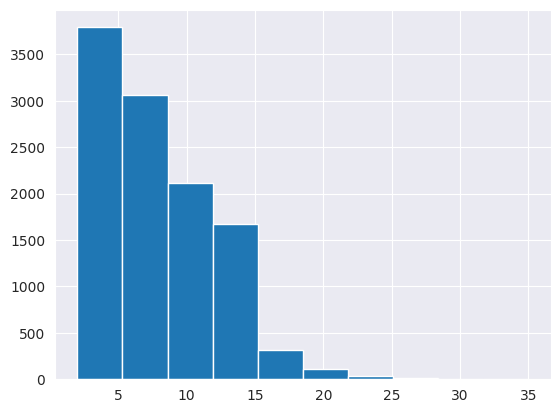

In [213]:
dialogs_lengths = [len(x) for x in dd_dataset['train']['dialog']]
plt.hist(dialogs_lengths)

## Phrase encoder model

In [214]:
# phrase_model = 'roberta-base'
# phrase_model = 'microsoft/deberta-v3-base'
# phrase_model = 'sentence-transformers/all-MiniLM-L12-v2'
# phrase_model = 'sentence-transformers/bert-base-nli-mean-tokens'
# phrase_model = 'intfloat/e5-base'
# phrase_model = 'cardiffnlp/twitter-xlm-roberta-base-sentiment'
phrase_model = 'sentence-transformers/paraphrase-mpnet-base-v2'
# phrase_model = 'sentence-transformers/sentence-t5-base'
# tokenizer = AutoTokenizer.from_pretrained(phrase_model)
# model = AutoModel.from_pretrained(phrase_model).to(device)
# model
sent_transformer = SentenceTransformer(model_name_or_path=phrase_model, device=device)
sent_transformer

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [215]:
sent_transformer.max_seq_length = 256
sent_transformer

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [216]:
test_phrases = ['Some day i will go to school',
                'To make maximum progress on addressing these pressing problems',
                'I will nether go to school',
                'I like to visit school',
                'The day will come when i will go to school']

phrases_encodings = sent_transformer.encode(test_phrases, convert_to_tensor=True, normalize_embeddings=False)
phrases_encodings.shape

torch.Size([5, 768])

In [217]:
F.cosine_similarity(phrases_encodings[0], phrases_encodings[1:])

tensor([0.0710, 0.8443, 0.6406, 0.9213], device='cuda:0')

In [218]:
torch.cdist(phrases_encodings, phrases_encodings)

tensor([[0.0000, 4.4946, 1.8611, 2.8869, 1.3281],
        [4.4946, 0.0000, 4.5073, 4.7039, 4.3278],
        [1.8611, 4.5073, 0.0000, 3.1569, 2.2718],
        [2.8869, 4.7039, 3.1569, 0.0000, 3.1362],
        [1.3281, 4.3278, 2.2718, 3.1362, 0.0000]], device='cuda:0')

## Dialog encoder model

Концептуально тут нужно:
- модель-кодировщик фраз (замоороженная) -> готовые эмбединги текста
- эмбединги участников диалога
- эмбединги позиции текста в диалоге
- кастомный токенизер c BOS и EOS
- causual lm crossentropy loss
- causual маска атеншена
- финальный классификатор в условный словарь

In [325]:
class DialogEmbeddings(nn.Module):
    def __init__(self, encoder_hidden_dim: int,
                 max_interlocutors_count: int,
                 max_dialogue_length: int,
                 dropout_p: float):
        super(DialogEmbeddings, self).__init__()

        self.padding_idx = 0  # special index for padding (must be in tokenizer)

        self.position_embeddings = nn.Embedding(max_dialogue_length + 1,  # padding
                                                encoder_hidden_dim, padding_idx=self.padding_idx)
        self.interlocutors_embeddings = nn.Embedding(max_interlocutors_count + 2,  # padding, eos, bos
                                                     encoder_hidden_dim, padding_idx=self.padding_idx)
        self.norm = nn.LayerNorm(encoder_hidden_dim)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, interlocutors_ids: torch.LongTensor, position_ids: torch.LongTensor = None):
        if position_ids is None:
            position_ids = self.create_position_ids_from_input_ids(interlocutors_ids)

        interlocutors_embeds = self.interlocutors_embeddings(interlocutors_ids)
        position_embeds = self.position_embeddings(position_ids)

        embeddings = interlocutors_embeds + position_embeds
        embeddings = self.norm(embeddings)
        embeddings = self.dropout(embeddings)

        return embeddings

    def create_position_ids_from_input_ids(self, input_ids):
        """
        Replace non-padding symbols with their position numbers. Position numbers begin at padding_idx+1. Padding symbols
        are ignored. This is modified from fairseq's `utils.make_positions`. :param torch.Tensor x: :return torch.Tensor:
        """
        # The series of casts and type-conversions here are carefully balanced to both work with ONNX export and XLA.
        mask = input_ids.ne(self.padding_idx).int()
        incremental_indices = torch.cumsum(mask, dim=1).type_as(mask) * mask
        return incremental_indices.long() + self.padding_idx

In [326]:
class DialogOutput(nn.Module):
    def __init__(self,
                 encoder_hidden_dim: int,
                 dim_feedforward_mult: int = 3,
                 dropout_p: float = 0.1):
        super(DialogOutput, self).__init__()

        self.inner_proj = nn.Linear(encoder_hidden_dim, dim_feedforward_mult * encoder_hidden_dim)
        self.norm = nn.LayerNorm(dim_feedforward_mult * encoder_hidden_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.out_proj = nn.Linear(dim_feedforward_mult * encoder_hidden_dim, encoder_hidden_dim)
        # self.norm2 = nn.LayerNorm(encoder_hidden_dim)

    def forward(self, inp: torch.FloatTensor):
        x = F.gelu(self.inner_proj(inp))
        x = self.norm(self.dropout(x))
        x = self.out_proj(x)
        x = x + inp
        return x

In [327]:
class DialogTransformer(nn.Module):
    def __init__(self, encoder_hidden_dim: int,
                 max_dialogue_length: int,
                 max_interlocutors_count: int,
                 decoder_n_layers: int = 2,
                 decoder_n_head: int = 4,
                 dim_feedforward_mult: int = 3,
                 dropout_p: float = 0.1):
        super(DialogTransformer, self).__init__()

        # self.bos_vector = nn.Parameter(torch.randn([encoder_hidden_dim]), requires_grad=True)
        self.eos_vector = nn.Parameter(torch.randn([encoder_hidden_dim]), requires_grad=True)

        self.input_norm = nn.LayerNorm(encoder_hidden_dim)
        self.dialogue_embeddings = DialogEmbeddings(encoder_hidden_dim, max_interlocutors_count,
                                                    max_dialogue_length, dropout_p)

        decoder_ff_inner_dim = encoder_hidden_dim * dim_feedforward_mult
        layer = nn.TransformerEncoderLayer(d_model=encoder_hidden_dim,
                                           nhead=decoder_n_head,
                                           dim_feedforward=decoder_ff_inner_dim,
                                           activation=F.gelu,  # using gelu instead of default relu
                                           dropout=dropout_p,
                                           batch_first=True)  # using encoder layers due to not a seq2seq setup
        self.model = nn.TransformerEncoder(layer, decoder_n_layers)

        # self.lstm_model = nn.LSTM(input_size=encoder_hidden_dim,
        #                           hidden_size=decoder_ff_inner_dim,
        #                           num_layers=decoder_n_layers,
        #                           bidirectional=False,
        #                           dropout=dropout_p,
        #                           batch_first=True)

        # self.logits_projector = DialogOutput(encoder_hidden_dim, dim_feedforward_mult, dropout_p=dropout_p)
        self.logits_projector = nn.Linear(in_features=encoder_hidden_dim, out_features=encoder_hidden_dim, bias=True)

        self.interlocutors_projector = nn.Linear(in_features=encoder_hidden_dim, out_features=max_interlocutors_count+1, bias=True)

    def forward(self, encodings: torch.FloatTensor,
                interlocutors_ids: torch.LongTensor,
                position_ids: torch.LongTensor = None,
                attention_mask: torch.BoolTensor = None,
                return_loss = True):
        """
        :param encodings: Pooled hiddens from sentence-transformer in shape [bs, lines_count, hidden_dim]
        :param labels: Labels for dialog lines
        :param interlocutors_ids: shape [bs, seq_len], interlocutors for each line (from one)
        :param position_ids: shape [bs, seq_len], position of line in dialogue (from one)
        :param attention_mask: shape [bs, seq_len], attention mask for padding where 1 is disabled and 0 is enabled
        """

        batch_size = encodings.shape[0]

        representation = torch.cat([
            # self.bos_vector.repeat([batch_size, 1, 1]),
            encodings,
            self.eos_vector.repeat([batch_size, 1, 1])
        ], dim=1)  # insert bos and eos vector

        x = self.input_norm(representation)
        x = x + self.dialogue_embeddings(interlocutors_ids=interlocutors_ids, position_ids=position_ids)

        if attention_mask is None:
            attention_mask = torch.zeros([batch_size, x.shape[1]]).bool().to(x.device)

        causal_mask = torch.triu(torch.ones(x.shape[1], x.shape[1]), diagonal=1).bool().to(x.device)  # only attend to past (not necessary, but logical...)
        x = self.model.forward(src=x,
                               mask=causal_mask,
                               src_key_padding_mask=attention_mask)

        # x, (ht, ct) = self.lstm_model(x)

        predicted_logits = self.logits_projector(x)
        predicted_interlocutors = self.interlocutors_projector(x)

        if return_loss:
            copied_interlocutors = interlocutors_ids.clone() - 1
            copied_interlocutors[copied_interlocutors < 0] = -100

            interlocutors_loss = compute_clm_loss(predicted_interlocutors, copied_interlocutors)
            logits_loss = compute_shifted_cosine_mse_loss(predicted_logits, representation, padding_mask=attention_mask)

            total_loss = logits_loss + interlocutors_loss

            return total_loss, interlocutors_loss, predicted_logits, predicted_interlocutors

        return predicted_logits, predicted_interlocutors

In [328]:
torch.triu(torch.ones(10, 10), diagonal=1).bool()

tensor([[False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True,  True,  True],
        [False, False, False, False,  True,  True,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True],
        [False, False, False, False, False, False, False,  True,  True,  True],
        [False, False, False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False, False, False,  True],
        [False, False, False, False, False, False, False, False, False, False]])

In [329]:
dialo_transformer = DialogTransformer(encoder_hidden_dim=768,
                                      max_dialogue_length=50,
                                      max_interlocutors_count=2,
                                      decoder_n_layers=2,
                                      decoder_n_head=4,
                                      dim_feedforward_mult=4,
                                      dropout_p=0.2
                                      ).to(sent_transformer.device).eval()
dialo_transformer

DialogTransformer(
  (input_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dialogue_embeddings): DialogEmbeddings(
    (position_embeddings): Embedding(51, 768, padding_idx=0)
    (interlocutors_embeddings): Embedding(4, 768, padding_idx=0)
    (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (model): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=3072, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=Fal

In [330]:
summary(dialo_transformer)

Layer (type:depth-idx)                                            Param #
DialogTransformer                                                 768
├─LayerNorm: 1-1                                                  1,536
├─DialogEmbeddings: 1-2                                           --
│    └─Embedding: 2-1                                             39,168
│    └─Embedding: 2-2                                             3,072
│    └─LayerNorm: 2-3                                             1,536
│    └─Dropout: 2-4                                               --
├─TransformerEncoder: 1-3                                         --
│    └─ModuleList: 2-5                                            --
│    │    └─TransformerEncoderLayer: 3-1                          7,087,872
│    │    └─TransformerEncoderLayer: 3-2                          7,087,872
├─Linear: 1-4                                                     590,592
├─Linear: 1-5                                                    

In [331]:
# from torch.nn import MultiheadAttention
# MultiheadAttention??

In [332]:
class DialogTokenizer:
    """
    Accepts dicts with keys: 'dialog' - required, 'interlocutors' and 'labels'
    Must return dict with 'encoder_hidden', 'interlocutors_ids' and 'labels'
    """

    def __init__(self, lines_encoder: SentenceTransformer,
                 all_interlocutors: list = None):

        self.lines_encoder = lines_encoder
        for p in self.lines_encoder[0].parameters():
            p.requires_grad = False

        self.padding_idx = 0
        # self.bos_idx = 1
        self.eos_idx = 1

        if all_interlocutors:
            all_interlocutors = set(all_interlocutors)
            self.id2interlocutors = dict(zip(range(2, len(all_interlocutors) + 2), all_interlocutors))
            self.interlocutor2id = {v: k for k, v in self.id2interlocutors.items()}

    def encode(self, dialog: List[str],
               interlocutors: List[int] = None,
               lines_batch_size: int = 50,
               unsqueeze: bool = True,
               return_loss: bool = True):

        encodings = self.lines_encoder.encode(sentences=dialog,
                                              batch_size=lines_batch_size,
                                              normalize_embeddings=False,  # better not to normalize
                                              show_progress_bar=False,
                                              convert_to_tensor=True)
        # encodings.requires_grad = False

        if interlocutors is None:
            interlocutors = [(i % 2) + 2 for i in range(len(dialog))]
        elif hasattr(self, 'interlocutor2id'):
            interlocutors = list(map(self.interlocutor2id.get, interlocutors))

        interlocutors = interlocutors + [self.eos_idx]

        result = {
            'encodings': encodings.unsqueeze(0) if unsqueeze else encodings,
            'interlocutors_ids': torch.LongTensor([interlocutors] if unsqueeze else interlocutors).to(encodings.device),
            'return_loss': return_loss
        }

        return result

    def encode_batch(self, dialog: List[List[str]],
                     interlocutors: List[List[int]] = None,
                     lines_batch_size: int = 50,
                     return_loss: bool = True):

        if interlocutors is None:
            interlocutors = [None] * len(dialog)
        unsqueeze = [False] * len(dialog)

        assert len(dialog) == len(interlocutors)

        zipped = zip(dialog, interlocutors, [lines_batch_size] * len(dialog), unsqueeze)
        encoded_batch = list(map(lambda x: self.encode(*x), zipped))

        encodings = pad_sequence([encode_dict['encodings'] for encode_dict in encoded_batch],
                                 batch_first=True,
                                 padding_value=self.padding_idx)
        encodings.requires_grad = False

        interlocutors_ids = pad_sequence([encode_dict['interlocutors_ids'] for encode_dict in encoded_batch],
                                         batch_first=True,
                                         padding_value=self.padding_idx)

        lengths = [len(dial) + 1 for dial in dialog]  # keep in mind bos and eos
        masks = list(map(lambda x: torch.zeros(size=[x]), lengths))
        attention_masks = pad_sequence(masks, batch_first=True, padding_value=1).bool().to(encodings.device)

        result = {
            'encodings': encodings,
            'interlocutors_ids': interlocutors_ids,
            'attention_mask': attention_masks,
            'return_loss': return_loss
        }

        return result

In [333]:
dialo_tokenizer = DialogTokenizer(sent_transformer,)

In [334]:
dialo_encoded = dialo_tokenizer.encode(['Hello man', 'Goodbye', 'Thanks'])
dialo_encoded

{'encodings': tensor([[[-0.0060,  0.0213, -0.0350,  ...,  0.1227,  0.0883, -0.1385],
          [-0.1030,  0.0213, -0.0218,  ...,  0.1145,  0.1353, -0.0227],
          [-0.1590, -0.1364, -0.0621,  ..., -0.0499,  0.1225, -0.0771]]],
        device='cuda:0'),
 'interlocutors_ids': tensor([[2, 3, 2, 1]], device='cuda:0'),
 'return_loss': True}

In [335]:
dialo_transformer.forward(**dialo_encoded)

(tensor(2.8566, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.1870, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor([[[ 0.8403, -1.0246,  0.6459,  ..., -0.0582,  0.2867, -0.9311],
          [ 0.4788, -1.2432,  0.2149,  ..., -0.1269, -0.2462,  0.3600],
          [ 0.2637, -0.8267, -0.0999,  ...,  0.0399,  0.8430, -0.4850],
          [-0.2287,  0.6210,  0.2625,  ...,  0.2015,  0.5411,  0.3481]]],
        device='cuda:0', grad_fn=<ViewBackward0>),
 tensor([[[-0.4627, -0.3020, -0.9830],
          [-0.8576,  0.2013, -0.2270],
          [-0.3021,  0.3460, -0.4432],
          [ 0.0061, -0.5514, -0.5011]]], device='cuda:0',
        grad_fn=<ViewBackward0>))

In [336]:
dialogs_encoded = dialo_tokenizer.encode_batch(dialog=[
    ['Hello', 'Hi there', 'Goodbye'], ['My name is', 'Stop', 'Go away', 'Please']
])
dialogs_encoded

{'encodings': tensor([[[-0.1000,  0.0136, -0.0275,  ...,  0.1817, -0.0039, -0.1345],
          [-0.0769, -0.2066, -0.0541,  ...,  0.1537,  0.0137, -0.0936],
          [-0.1030,  0.0213, -0.0218,  ...,  0.1145,  0.1353, -0.0227],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[-0.0664, -0.0605,  0.0674,  ...,  0.0133,  0.0375, -0.0828],
          [-0.2907,  0.0527, -0.0544,  ...,  0.1449,  0.0805,  0.0240],
          [-0.0519,  0.1118,  0.0433,  ...,  0.1584,  0.0710,  0.0479],
          [-0.1146,  0.1408, -0.0545,  ..., -0.0027,  0.1091, -0.0393]]],
        device='cuda:0'),
 'interlocutors_ids': tensor([[2, 3, 2, 1, 0],
         [2, 3, 2, 3, 1]], device='cuda:0'),
 'attention_mask': tensor([[False, False, False, False,  True],
         [False, False, False, False, False]], device='cuda:0'),
 'return_loss': True}

In [337]:
dialo_transformer.forward(**dialogs_encoded)

(tensor(2.7416, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.2946, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor([[[ 0.9142, -0.8341,  0.3065,  ...,  0.1835,  0.6315, -0.4177],
          [ 0.6381, -1.0293,  0.1844,  ..., -0.3488,  0.0772,  0.4306],
          [ 0.1184, -0.8992, -0.3219,  ...,  0.2437,  0.7100, -0.2873],
          [-1.0385,  0.2369, -0.6214,  ...,  0.4448,  0.8912,  0.5903],
          [ 0.3089,  0.7537,  0.8462,  ...,  0.3665,  0.1596, -0.4438]],
 
         [[ 0.9228, -1.2609,  0.0737,  ...,  0.3191,  1.0034, -0.7359],
          [ 0.4104, -0.6578, -0.1195,  ..., -0.0142,  0.2446,  0.3401],
          [-0.2627, -0.6756, -0.0721,  ...,  0.5098,  1.0123, -0.6795],
          [ 0.1883, -0.5296, -0.3300,  ...,  0.2569,  0.7108,  0.5082],
          [ 0.3537,  0.5046,  0.1305,  ...,  0.3377,  0.1120, -0.6320]]],
        device='cuda:0', grad_fn=<ViewBackward0>),
 tensor([[[-0.0873, -0.2479, -0.6059],
          [-0.9294, -0.1228, -0.3811],
          [-0.5265,  0.529

## Training

In [338]:
# Accepts list of dialog dicts per batch
def collate_batch(batch: list):
    v = {k: [dic[k] for dic in batch] for k in batch[0].keys()}  # list of dicts to dict of lists
    return v

In [339]:
dd_dataset['train'] = dd_dataset['train'].remove_columns(['act', 'emotion'])
dd_dataset['validation'] = dd_dataset['validation'].remove_columns(['act', 'emotion'])
dd_dataset['test'] = dd_dataset['test'].remove_columns(['act', 'emotion'])
dd_dataset

ValueError: Column name act not in the dataset. Current columns in the dataset: ['dialog']

In [340]:
train_dataloader = DataLoader(dd_dataset['train'], collate_fn=collate_batch, shuffle=True, batch_size=128)
eval_dataloader = DataLoader(dd_dataset['validation'], collate_fn=collate_batch, shuffle=True, batch_size=128)
test_dataloader = DataLoader(dd_dataset['test'], collate_fn=collate_batch, shuffle=True, batch_size=128)

In [341]:
from torch.optim import AdamW
from transformers import get_scheduler

In [342]:
optimizer = AdamW(dialo_transformer.parameters(), lr=5e-4)

In [344]:
num_epochs = 15
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(name="cosine_with_restarts", optimizer=optimizer, num_warmup_steps=10,
                             num_training_steps=num_training_steps)

In [345]:
def evaluate(model: DialogTransformer, tokenizer: DialogTokenizer, data_loader):
    model.eval()
    losses = []
    for batch in tqdm(data_loader):
        with torch.inference_mode():
            tokenized_input = tokenizer.encode_batch(**batch)
            loss, i1, i2, i3 = dialo_transformer.forward(**tokenized_input)
            del i1, i2, i3
        losses.append(loss.detach().item())
    return losses

In [346]:
evaluate(dialo_transformer, dialo_tokenizer, eval_dataloader)

  0%|          | 0/8 [00:00<?, ?it/s]

[2.496969223022461,
 2.495931386947632,
 2.5014333724975586,
 2.491014003753662,
 2.4800643920898438,
 2.485868215560913,
 2.5064473152160645,
 2.4883999824523926]

In [347]:
def create_experiment_info(best_epoch_n, best_train_loss, best_eval_loss, losses_history = None, file_name='experiment_info.json'):
    result_dict = {
        'best_epoch': {
            'number': best_epoch_n,
            'train_loss': best_train_loss,
            'eval_loss': best_eval_loss
        }
    }
    if losses_history is not None:
        result_dict['history'] = losses_history
    with open(file_name, 'w') as outfile:
        json.dump(result_dict, outfile, indent=4)

In [348]:
def train(model: DialogTransformer, tokenizer: DialogTokenizer, checkpoints_dir):
    Path(checkpoints_dir).mkdir(parents=True, exist_ok=True)
    losses_history = {
        'train': [],
        'eval': []
    }
    progress_bar = tqdm(range(num_training_steps))
    min_eval_loss = 999999999.9
    for epoch in range(num_epochs):
        model.train()
        print(f'Starting epoch {epoch}...')
        train_losses = []

        for batch in train_dataloader:
            tokenized_input = tokenizer.encode_batch(**batch)
            loss, i1, i2, i3 = dialo_transformer.forward(**tokenized_input)
            loss.backward()

            train_losses.append(loss.item())

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

            del i2, i3

        train_loss = np.array(train_losses).mean()
        eval_loss = np.array(evaluate(dialo_transformer, dialo_tokenizer, eval_dataloader)).mean()

        losses_history['train'].append(train_loss)
        losses_history['eval'].append(eval_loss)

        print(f'[TRAIN] Mean epoch loss: {train_loss}')
        print(f'[EVAL] Mean epoch loss: {eval_loss}')

        if eval_loss < min_eval_loss:
            save_path = checkpoints_dir + 'best_model.pth'
            print(f'Current best on eval, saving model to {save_path}...')
            torch.save(model, save_path)
            create_experiment_info(best_epoch_n=epoch, best_train_loss=train_loss, best_eval_loss=eval_loss,
                                   losses_history=losses_history, file_name=checkpoints_dir + 'experiment_info.json')
            min_eval_loss = eval_loss

    return losses_history

In [349]:
losses_history = train(dialo_transformer, dialo_tokenizer, './experiments/pmpn_eos_shift_tr_2l4h_COS&MSE_d0.2_15M/')

  0%|          | 0/1305 [00:00<?, ?it/s]

Starting epoch 0...


  0%|          | 0/8 [00:00<?, ?it/s]

[TRAIN] Mean epoch loss: 1.2173487098737694
[EVAL] Mean epoch loss: 0.9656231626868248
Current best on eval, saving model to ./experiments/pmpn_eos_shift_tr_2l4h_COS&MSE_d0.2_15M/best_model.pth...
Starting epoch 1...


  0%|          | 0/8 [00:00<?, ?it/s]

[TRAIN] Mean epoch loss: 1.005477902532994
[EVAL] Mean epoch loss: 0.9043259471654892
Current best on eval, saving model to ./experiments/pmpn_eos_shift_tr_2l4h_COS&MSE_d0.2_15M/best_model.pth...
Starting epoch 2...


  0%|          | 0/8 [00:00<?, ?it/s]

[TRAIN] Mean epoch loss: 0.9399584888041704
[EVAL] Mean epoch loss: 0.9002432003617287
Current best on eval, saving model to ./experiments/pmpn_eos_shift_tr_2l4h_COS&MSE_d0.2_15M/best_model.pth...
Starting epoch 3...


  0%|          | 0/8 [00:00<?, ?it/s]

[TRAIN] Mean epoch loss: 0.9051854706358635
[EVAL] Mean epoch loss: 0.8669495806097984
Current best on eval, saving model to ./experiments/pmpn_eos_shift_tr_2l4h_COS&MSE_d0.2_15M/best_model.pth...
Starting epoch 4...


  0%|          | 0/8 [00:00<?, ?it/s]

[TRAIN] Mean epoch loss: 0.8800069861028387
[EVAL] Mean epoch loss: 0.8603663817048073
Current best on eval, saving model to ./experiments/pmpn_eos_shift_tr_2l4h_COS&MSE_d0.2_15M/best_model.pth...
Starting epoch 5...


  0%|          | 0/8 [00:00<?, ?it/s]

[TRAIN] Mean epoch loss: 0.8528773346166502
[EVAL] Mean epoch loss: 0.8520498275756836
Current best on eval, saving model to ./experiments/pmpn_eos_shift_tr_2l4h_COS&MSE_d0.2_15M/best_model.pth...
Starting epoch 6...


  0%|          | 0/8 [00:00<?, ?it/s]

[TRAIN] Mean epoch loss: 0.8272491693496704
[EVAL] Mean epoch loss: 0.8429921194911003
Current best on eval, saving model to ./experiments/pmpn_eos_shift_tr_2l4h_COS&MSE_d0.2_15M/best_model.pth...
Starting epoch 7...


  0%|          | 0/8 [00:00<?, ?it/s]

[TRAIN] Mean epoch loss: 0.8036789510441923
[EVAL] Mean epoch loss: 0.8549497872591019
Starting epoch 8...


  0%|          | 0/8 [00:00<?, ?it/s]

[TRAIN] Mean epoch loss: 0.7782610956279711
[EVAL] Mean epoch loss: 0.850077211856842
Starting epoch 9...


  0%|          | 0/8 [00:00<?, ?it/s]

[TRAIN] Mean epoch loss: 0.7561562218885313
[EVAL] Mean epoch loss: 0.8705039396882057
Starting epoch 10...


  0%|          | 0/8 [00:00<?, ?it/s]

[TRAIN] Mean epoch loss: 0.7369650341998571
[EVAL] Mean epoch loss: 0.8759426102042198
Starting epoch 11...


  0%|          | 0/8 [00:00<?, ?it/s]

[TRAIN] Mean epoch loss: 0.7193578604994149
[EVAL] Mean epoch loss: 0.8850851804018021
Starting epoch 12...


  0%|          | 0/8 [00:00<?, ?it/s]

[TRAIN] Mean epoch loss: 0.7088298043985476
[EVAL] Mean epoch loss: 0.8874960690736771
Starting epoch 13...


  0%|          | 0/8 [00:00<?, ?it/s]

[TRAIN] Mean epoch loss: 0.7015573937317421
[EVAL] Mean epoch loss: 0.8962971344590187
Starting epoch 14...


  0%|          | 0/8 [00:00<?, ?it/s]

[TRAIN] Mean epoch loss: 0.6980681344010364
[EVAL] Mean epoch loss: 0.8935330137610435


In [ ]:
dialo_transformer = torch.load('./experiments/pmpn_1l_4h_COS&MSE_d0.1/best_model.pth').eval()
dialo_transformer

In [248]:
evaluate(dialo_transformer, dialo_tokenizer, test_dataloader)

  0%|          | 0/8 [00:00<?, ?it/s]

[0.9237592816352844,
 0.9070261716842651,
 0.950858473777771,
 0.8814290761947632,
 0.8824372887611389,
 0.9190113544464111,
 0.9275416135787964,
 0.8859769105911255]

## Tests

In [311]:
dd_dataset['train']['dialog'][14]

['Ah , ah , ah ... ',
 " All right , Bill.Here ' s your daily exercise schedule . You are to jog before breakfast . ",
 ' Jog ? ',
 ' Then , you are to walk to work . ',
 ' Walk ? ',
 ' Thirty minutes in gym at lunch time . ',
 ' Oh no . ',
 ' Use the stairs , never the elevator . ',
 ' Oh , dear . ',
 ' And three times a week , you can either swim , play racketball , or hand ball . ',
 ' Oh no . ',
 " OK , you can stop now.It ' s time for the dance class . ",
 " Dance class ! I don't know how . ",
 ' You will . ',
 ' Oh ... ']

In [312]:
test_encoded = dialo_tokenizer.encode(dd_dataset['train']['dialog'][14])
test_encoded

{'encodings': tensor([[[-0.0103,  0.1684, -0.0691,  ...,  0.1169, -0.0007, -0.1451],
          [-0.0941,  0.0757, -0.0304,  ...,  0.0930, -0.2517,  0.0010],
          [-0.0930, -0.0974, -0.0908,  ...,  0.0892, -0.0962,  0.0261],
          ...,
          [ 0.0306, -0.0410, -0.0153,  ...,  0.1048,  0.1243,  0.0121],
          [-0.0457,  0.4035, -0.0132,  ...,  0.1135,  0.0317, -0.0892],
          [ 0.0376,  0.1684, -0.1105,  ...,  0.0079, -0.1181, -0.2239]]],
        device='cuda:0'),
 'interlocutors_ids': tensor([[2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 1]], device='cuda:0'),
 'return_loss': True}

In [313]:
with torch.inference_mode():
    test_output = dialo_transformer.forward(**test_encoded)
test_output

(tensor(0.6839, device='cuda:0'),
 tensor(0.0247, device='cuda:0'),
 tensor([[[-0.0054,  0.2533, -0.0621,  ...,  0.1817, -0.0858, -0.1744],
          [-0.0472,  0.2055, -0.0639,  ...,  0.1937, -0.2100, -0.0826],
          [-0.0577,  0.1250, -0.0506,  ...,  0.1641, -0.1539, -0.0822],
          ...,
          [-0.0987,  0.2450, -0.0656,  ...,  0.1326, -0.0793, -0.1174],
          [-0.0833,  0.3241, -0.1029,  ...,  0.1071, -0.1333, -0.1488],
          [ 0.0911, -0.0708, -0.2612,  ...,  0.3676, -0.3488, -0.0472]]],
        device='cuda:0'),
 tensor([[[-1.6289, -3.6384,  4.8216],
          [-0.6677,  5.9705, -3.8075],
          [-0.9473, -2.9548,  3.4717],
          [ 0.1636,  4.8853, -3.8278],
          [-1.4058, -3.8429,  4.7044],
          [-0.0464,  5.7073, -4.0799],
          [-1.2514, -4.0976,  4.9222],
          [ 0.3383,  5.2997, -4.1880],
          [-0.0505, -4.4959,  3.9795],
          [-0.2033,  5.1663, -3.4534],
          [ 0.4945, -5.1131,  4.1055],
          [ 1.4640,  4.6333,

In [252]:
F.mse_loss(test_encoded['encodings'][0][1:].detach(),
           test_encoded['encodings'][0][:-1].detach(), reduction='none').mean(-1)

tensor([0.0079, 0.0218, 0.0166, 0.0125, 0.0190, 0.0195, 0.0222, 0.0111],
       device='cuda:0')

In [253]:
F.mse_loss(test_output[1][0].detach(),
           test_encoded['encodings'][0].detach(), reduction='none').mean(-1)

/tmp/ipykernel_50041/2758299011.py:1: UserWarning: Using a target size (torch.Size([9, 768])) that is different to the input size (torch.Size([10, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.mse_loss(test_output[1][0].detach(),


RuntimeError: The size of tensor a (10) must match the size of tensor b (9) at non-singleton dimension 0

In [316]:
torch.cdist(test_encoded['encodings'][0].detach(), test_encoded['encodings'][0].detach())

tensor([[0.0000, 4.1069, 4.3854, 4.2318, 4.2074, 4.3881, 3.7951, 4.1927, 3.2442,
         4.3049, 3.7951, 3.7929, 4.2565, 3.9215, 2.3609],
        [4.1069, 0.0000, 2.9001, 3.5279, 3.6740, 3.1960, 4.4397, 4.0415, 4.2673,
         3.7079, 4.4397, 3.6758, 4.2172, 3.9979, 4.1196],
        [4.3854, 2.9001, 0.0000, 4.0644, 3.3790, 3.3917, 4.4951, 4.2465, 4.5239,
         4.0350, 4.4951, 4.0545, 4.1159, 4.4436, 4.4061],
        [4.2318, 3.5279, 4.0644, 0.0000, 3.0401, 4.2472, 4.4114, 3.9599, 4.2616,
         4.1153, 4.4114, 4.1545, 4.4685, 3.8570, 4.2276],
        [4.2074, 3.6740, 3.3790, 3.0401, 0.0000, 4.2362, 4.3700, 3.9190, 4.2597,
         4.1915, 4.3700, 3.9400, 4.0513, 4.1252, 4.2156],
        [4.3881, 3.1960, 3.3917, 4.2472, 4.2362, 0.0000, 4.5586, 4.1508, 4.5284,
         3.4303, 4.5586, 3.6911, 3.8418, 4.6737, 4.4486],
        [3.7951, 4.4397, 4.4951, 4.4114, 4.3700, 4.5586, 0.0000, 3.7496, 3.2890,
         4.5234, 0.0000, 3.9934, 4.4479, 4.2542, 3.4534],
        [4.1927, 4.0415, 4.

In [317]:
cosine_similarity(test_encoded['encodings'][0].cpu(), test_encoded['encodings'][0].cpu())

array([[ 1.        ,  0.15790567,  0.09273249,  0.11650714,  0.1552225 ,
         0.09158262,  0.2808028 ,  0.114875  ,  0.48645896,  0.07288989,
         0.2808028 ,  0.27564257,  0.12037336,  0.24630192,  0.7235265 ],
       [ 0.15790567,  1.0000002 ,  0.61616194,  0.40563208,  0.37585837,
         0.533515  ,  0.04750321,  0.20445731,  0.13855869,  0.33457285,
         0.04750321,  0.3418637 ,  0.16368568,  0.24134715,  0.18388458],
       [ 0.09273249,  0.61616194,  0.9999999 ,  0.2527678 ,  0.49875173,
         0.5003265 ,  0.07558285,  0.16905624,  0.08226644,  0.25432837,
         0.07558285,  0.2426284 ,  0.24468377,  0.11178365,  0.11592379],
       [ 0.11650714,  0.40563208,  0.2527678 ,  0.9999999 ,  0.5773941 ,
         0.18393034,  0.07033902,  0.24510682,  0.15042621,  0.18970096,
         0.07033902,  0.16897836,  0.07142068,  0.3017862 ,  0.15029277],
       [ 0.1552225 ,  0.37585837,  0.49875173,  0.5773941 ,  1.        ,
         0.21211526,  0.11638689,  0.2842696 , 

In [320]:
torch.cdist(test_output[2][0], test_output[2][0])

tensor([[0.0000, 2.2734, 2.0998, 2.7346, 2.7159, 2.9733, 1.5934, 2.1232, 1.7050,
         3.1253, 1.6709, 2.5840, 3.2646, 2.0620, 1.6717, 6.3625],
        [2.2734, 0.0000, 1.4396, 1.6791, 1.8385, 1.3594, 1.6308, 1.6408, 1.7323,
         1.8945, 1.6733, 2.0502, 2.5075, 1.8503, 2.4434, 6.1954],
        [2.0998, 1.4396, 0.0000, 2.0194, 1.6432, 1.7038, 1.5826, 1.8199, 1.8213,
         2.3624, 1.5903, 2.2806, 2.5148, 1.8953, 2.2275, 6.2978],
        [2.7346, 1.6791, 2.0194, 0.0000, 1.6356, 1.9076, 1.9482, 1.7777, 2.0726,
         2.3458, 1.9900, 2.5027, 2.8806, 2.0212, 2.7001, 6.6032],
        [2.7159, 1.8385, 1.6432, 1.6356, 0.0000, 1.8432, 1.9687, 1.8321, 2.1143,
         2.3798, 1.9909, 2.4990, 2.5622, 2.2019, 2.6260, 6.4537],
        [2.9733, 1.3594, 1.7038, 1.9076, 1.8432, 0.0000, 2.1214, 2.1086, 2.2048,
         1.7798, 2.0978, 2.1779, 2.3158, 2.3044, 2.9055, 6.3156],
        [1.5934, 1.6308, 1.5826, 1.9482, 1.9687, 2.1214, 0.0000, 1.6770, 0.9452,
         2.4744, 0.4019, 2.3578, 2.80

In [321]:
cosine_similarity(test_output[2][0].cpu(), test_output[2][0].cpu())

array([[1.        , 0.8088258 , 0.7897816 , 0.719144  , 0.704582  ,
        0.69052804, 0.882852  , 0.8322343 , 0.87681556, 0.741297  ,
        0.87235296, 0.8042887 , 0.71701777, 0.802703  , 0.8782024 ,
        0.4413397 ],
       [0.8088258 , 1.0000001 , 0.9370428 , 0.90465057, 0.88142323,
        0.9416651 , 0.9084791 , 0.90830594, 0.89291596, 0.9179991 ,
        0.90199155, 0.881487  , 0.8449291 , 0.87772524, 0.7798788 ,
        0.48842746],
       [0.7897816 , 0.9370428 , 1.        , 0.852502  , 0.8963144 ,
        0.9199401 , 0.874556  , 0.8821808 , 0.8541694 , 0.8914889 ,
        0.8756376 , 0.8648577 , 0.86965835, 0.8188772 , 0.77020246,
        0.45904002],
       [0.719144  , 0.90465057, 0.852502  , 0.99999976, 0.906376  ,
        0.8839818 , 0.8625478 , 0.8923702 , 0.84478676, 0.86452353,
        0.85571444, 0.8197846 , 0.7891209 , 0.8508991 , 0.72971463,
        0.39265084],
       [0.704582  , 0.88142323, 0.8963144 , 0.906376  , 1.        ,
        0.88993466, 0.84495044, 

In [322]:
torch.cdist(test_output[2][0], test_encoded['encodings'][0])

tensor([[2.8510, 3.6089, 4.2648, 3.8091, 3.8867, 4.2695, 3.5289, 4.1104, 2.7641,
         3.8951, 3.5289, 3.3130, 4.2320, 3.2051, 2.8737],
        [3.8565, 2.8241, 3.8928, 3.8030, 3.9234, 3.6076, 4.2010, 4.4479, 3.5562,
         3.7087, 4.2010, 3.4794, 4.3094, 3.7405, 3.5147],
        [3.4233, 2.6156, 3.1798, 3.2939, 3.4030, 3.1691, 3.7193, 3.8341, 3.2288,
         3.1485, 3.7193, 2.9924, 3.8031, 3.1931, 3.2125],
        [4.0874, 3.2980, 4.0922, 3.1800, 3.8168, 3.8462, 4.1764, 4.4409, 3.6749,
         3.9560, 4.1764, 3.7993, 4.3695, 3.9264, 3.6859],
        [4.0343, 3.0715, 3.7143, 3.2754, 3.2186, 3.5657, 4.1791, 4.0101, 3.7357,
         3.5709, 4.1791, 3.5518, 4.1522, 3.7547, 3.7564],
        [4.2393, 3.0261, 3.8623, 3.8334, 4.0260, 3.1063, 4.4775, 4.5144, 3.9729,
         3.4988, 4.4775, 3.5510, 4.3251, 4.0624, 3.9496],
        [3.3792, 3.1575, 3.9880, 3.3661, 3.6529, 3.7825, 3.4217, 3.9212, 2.8901,
         3.5045, 3.4217, 3.1687, 4.1832, 3.1710, 3.0804],
        [3.7243, 3.5450, 4.

In [324]:
cosine_similarity(test_output[2][0][:-1].cpu(), test_encoded['encodings'][0].cpu())

array([[0.61240834, 0.39606062, 0.19933596, 0.33439296, 0.32772204,
        0.1975444 , 0.42242968, 0.21023484, 0.6527048 , 0.29509702,
        0.42242968, 0.48731837, 0.19031198, 0.5315366 , 0.6189385 ],
       [0.4008254 , 0.693552  , 0.42703247, 0.43596533, 0.41285384,
        0.50899744, 0.30240712, 0.21114874, 0.5117265 , 0.4592294 ,
        0.30240712, 0.5240295 , 0.28052935, 0.45718893, 0.5180512 ],
       [0.38921118, 0.65606827, 0.5213343 , 0.4607897 , 0.4441473 ,
        0.5245586 , 0.30345193, 0.25354064, 0.4873229 , 0.5002415 ,
        0.30345193, 0.54551655, 0.2924835 , 0.49676663, 0.48331466],
       [0.32421252, 0.5763266 , 0.3660668 , 0.6098894 , 0.44489267,
        0.44087878, 0.3108157 , 0.21377544, 0.47780806, 0.3825348 ,
        0.3108157 , 0.42918497, 0.2600621 , 0.4006325 , 0.46851206],
       [0.3021291 , 0.60992146, 0.44999203, 0.5588709 , 0.5842282 ,
        0.4933554 , 0.2701199 , 0.3243491 , 0.4282776 , 0.4688541 ,
        0.2701199 , 0.47208145, 0.29570097, 

In [260]:
torch.cdist(test_output[1][0][1:], test_encoded['encodings'][0][:-1])

tensor([[2.5671, 2.7597, 3.3063, 2.9722, 2.8253, 3.3752, 3.6660, 2.9233],
        [3.2390, 3.1299, 2.5967, 2.7111, 2.7886, 3.4478, 3.6980, 3.2700],
        [3.0660, 3.2342, 3.3027, 2.5255, 2.8296, 3.4488, 3.8317, 3.0841],
        [3.4916, 3.5352, 3.4793, 3.1186, 2.6600, 3.8441, 4.1601, 3.2892],
        [3.0600, 3.1149, 3.1777, 2.8568, 2.8587, 2.7464, 3.3875, 2.6347],
        [3.2911, 3.6312, 3.7015, 3.3788, 3.3048, 3.4174, 3.4775, 3.1840],
        [3.4213, 3.6574, 3.7432, 3.3750, 3.2135, 3.4877, 4.0184, 2.3332],
        [3.7509, 3.8965, 4.0852, 3.8383, 3.8490, 3.7951, 3.8789, 2.9148],
        [4.4709, 4.6435, 4.9981, 4.7081, 4.4533, 4.7905, 5.1068, 4.5436]],
       device='cuda:0')

In [261]:
F.mse_loss(test_output[1][0][1:].detach(),
           test_output[1][0][:-1].detach(), reduction='none').mean(-1)

tensor([0.0022, 0.0049, 0.0040, 0.0033, 0.0057, 0.0036, 0.0052, 0.0104, 0.0269],
       device='cuda:0')

In [315]:
test_output[3].softmax(-1).argmax(-1)

tensor([[2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 0, 0]], device='cuda:0')